# Preprocessing Notebook for 10x Genomics scATAC-seq Data Set

In this notebook we demonstrate the preprocessing steps that are applied to the  10x Genomics [10k PMBC scATAC-seq](https://www.10xgenomics.com/resources/datasets/10-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-next-gem-v-1-1-1-1-standard-2-0-0) dataset before we apply the EMBEDR algorithm.  These steps are a synthesis of those demonstrated in the [epiScanpy tutorial](https://nbviewer.org/github/colomemaria/epiScanpy/blob/master/docs/tutorials/Buenrostro_PBMC_data_processing.html), the Signac package (part of Seurat) [vignette](https://satijalab.org/signac/articles/pbmc_vignette.html) and the [SnapATAC tutorial](https://github.com/r3fang/SnapATAC/blob/master/examples/10X_brain_5k/README.md).  

Specifically, in this preprocessing, we download the filtered counts-by-peaks matrix for the [10k PMBC data set](https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5) as well as the [full fragments tsv](https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_fragments.tsv.gz).  We then merge the various metadatas and assign each peak to a gene using the [Gencode human genome annotation](https://www.gencodegenes.org/human/). Using the fragments we can then assess the extent to which each cell's reads are enriched for transcription start sites (TSSs) and filter out cells with low TSS enrichment.  We also filter out peaks that appear in too few cells ($\leq 10$) and cells that contain too few peaks ($\leq 200$).  We then normalize using [term frequency-inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) normalization after which we use a truncated SVD to reduce the dimensionality of the data.  We omit other common steps such as reducing to "most variable peaks" because they do not appear to have much effect (see [comment](https://satijalab.org/signac/articles/pbmc_vignette.html#normalization-and-linear-dimensional-reduction-1) in Signac vignette).

In [1]:
import anndata as ad
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import scanpy as sc
import scipy.stats as st
import scipy.sparse as sp
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

from read_h5 import *
from tss_enrichment_utility import *
from find_genes import *

%matplotlib inline

sns.set(color_codes=True)
matplotlib.rc("font", size=12)
matplotlib.rc("xtick", labelsize=12)
matplotlib.rc("ytick", labelsize=12)
matplotlib.rc("axes", labelsize=16)
matplotlib.rc("axes", titlesize=20)
matplotlib.rc("legend", fontsize=10)
matplotlib.rc("figure", titlesize=16)

In [2]:
# !wget https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5 -P ../data/10kPBMC_scATAC/00_raw_data/
# !wget https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_analysis.tar.gz -P ../data/10kPBMC_scATAC/01_clustering_analysis/
# !tar -xvf ../data/10kPBMC_scATAC/01_clustering_analysis/*tar.gz -C ../data/10kPBMC_scATAC/01_clustering_analysis/
# !rm ../data/10kPBMC_scATAC/01_clustering_analysis/*.tar.gz

In [3]:
adata = read_h5("../data/10kPBMC_scATAC/00_raw_data/atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5")

In [4]:
adata.var = adata.var.rename(columns={'name': 'peak_ID'}).set_index('peak_ID')

adata.var['chromosome'] = [name.split(':')[0] for name in adata.var.index]
adata.var['start'] = [int(name.split(":")[1].split("-")[0]) for name in adata.var.index]
adata.var['stop'] = [int(name.split(":")[1].split("-")[1]) for name in adata.var.index]

adata

AnnData object with n_obs × n_vars = 9688 × 144023
    var: 'chromosome', 'start', 'stop'
    uns: 'omic'

## Get the genome annotations!

Downstream it will be useful to have gene annotations for the peaks.  We can load the annotations using the `get_gtf_annotations` function.

In [5]:
# !wget http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz -P ../data/10kPBMC_scATAC/

In [6]:
feature_type='gene'
annotation_source = 'HAVANA'

gtf = get_gtf_annotations("../data/10kPBMC_scATAC/gencode.v38.annotation.gtf.gz",
                          feature_type=feature_type,
                          annotation=annotation_source)
gtf.head()

,seqname,source,feature,start,end,score,strand,attribute,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,tag
0,chr1,HAVANA,gene,11869,14409,.,+,.,"""ENSG00000223972.5""","""transcribed_unprocessed_pseudogene""","""DDX11L1""",2,"""HGNC:37102""","""OTTHUMG00000000961.2""",NaN
12,chr1,HAVANA,gene,14404,29570,.,-,.,"""ENSG00000239906.1""","""lncRNA""","""RP11-34P13.14""",2,NaN,"""OTTHUMG00000002481.1""",NaN
28,chr1,HAVANA,gene,29554,31109,.,+,.,"""ENSG00000225972.1""","""unprocessed_pseudogene""","""MTND1P23""",2,"""HGNC:42092""","""OTTHUMG00000002338.1""",NaN
39,chr1,HAVANA,gene,34554,36081,.,-,.,"""ENSG00000229905.1""","""lncRNA""","""RP11-206L10.4""",2,NaN,"""OTTHUMG00000002408.1""",NaN
47,chr1,HAVANA,gene,52473,53312,.,+,.,"""ENSG00000230368.2""","""lncRNA""","""FAM41C""",2,"""HGNC:27635""","""OTTHUMG00000002469.1""",NaN


## Match peaks to genes.

We can then give the identified peaks a gene annotation by finding genes that overlap with the identified peaks.  This is done with the `match_genes_to_peaks` function.

In [7]:
upstream, downstream = 2000, 0

match_genes_to_peaks(adata,
                     gtf,
                     upstream=upstream,
                     downstream=downstream,
                     verbose=False)

adata.var

/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,chromosome,start,stop,gene_name
peak_ID,,,,
chr1:9781-10672,chr1,9781,10672,DDX11L1
chr1:180678-181311,chr1,180678,181311,RP4-740C4.7
chr1:184004-184867,chr1,184004,184867,RP4-740C4.7
chr1:186550-187463,chr1,186550,187463,HES5
chr1:191198-192095,chr1,191198,192095,HES5
...,...,...,...,...
KI270713.1:21358-22260,KI270713.1,21358,22260,NaN
KI270713.1:25966-26842,KI270713.1,25966,26842,NaN
KI270713.1:29713-30529,KI270713.1,29713,30529,NaN


## Filter cells and peaks

Now that we have the data loaded, we can perform quality control filtering.  Specifically, we're going to filter out peaks that don't appear in enough cells and cells that don't have enough reads or peaks.

In [8]:
## First we make sure that all cells have one gene and that all genes have one cell.
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.filter_cells(adata, min_genes=1)

adata.obs['n_peaks'] = adata.obs['n_genes']
adata.obs['log_n_peaks'] = np.log10(adata.obs['n_peaks'])
adata.var['log_n_cells'] = np.log10(adata.var['n_cells'])

adata

AnnData object with n_obs × n_vars = 9688 × 144023
    obs: 'n_genes', 'n_peaks', 'log_n_peaks'
    var: 'chromosome', 'start', 'stop', 'gene_name', 'n_cells', 'log_n_cells'
    uns: 'omic'

Based on the violin plots below, we can set some minimal thresholds for the number of cells and peaks in a sample/feature.  We'll set these thresholds pretty conservatively, based on what other pipelines use.  In particular, while we could set thresholds on the maximum number of cells or peaks, it doesn't seem to be common practice.

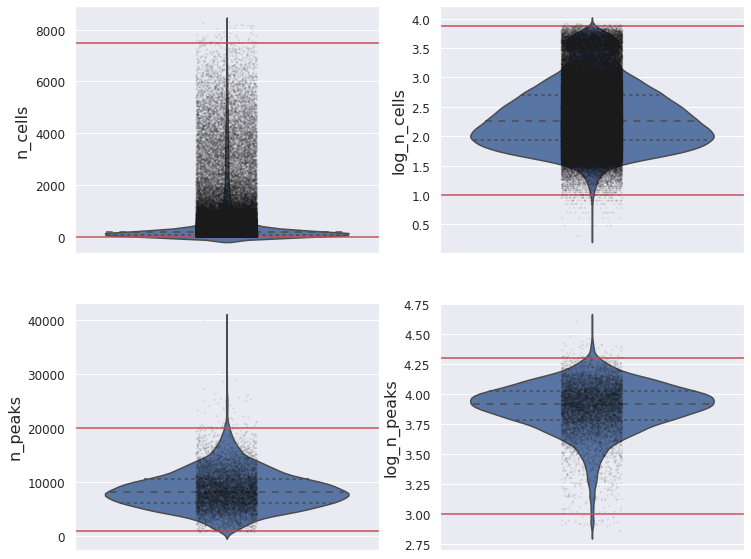

In [9]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 10))

min_cells, max_cells = int(10), int(7500)
min_peaks, max_peaks = int(1000), int(2.e4)

_ = sns.violinplot(data=adata.var, y='n_cells', ax=ax1, inner='quartile')
_ = sns.stripplot(data=adata.var, y='n_cells', s=2, color='k', alpha=0.1, ax=ax1)
_ = ax1.axhline(max_cells, color='r')
_ = ax1.axhline(min_cells, color='r')

_ = sns.violinplot(data=adata.var, y='log_n_cells', ax=ax2, inner='quartile')
_ = sns.stripplot(data=adata.var, y='log_n_cells', s=2, color='k', alpha=0.1, ax=ax2)
_ = ax2.axhline(np.log10(max_cells), color='r')
_ = ax2.axhline(np.log10(min_cells), color='r')

_ = sns.violinplot(data=adata.obs, y='n_peaks', ax=ax3, inner='quartile')
_ = sns.stripplot(data=adata.obs, y='n_peaks', s=2, color='k', alpha=0.1, ax=ax3)
_ = ax3.axhline(max_peaks, color='r')
_ = ax3.axhline(min_peaks, color='r')

_ = sns.violinplot(data=adata.obs, y='log_n_peaks', ax=ax4, inner='quartile')
_ = sns.stripplot(data=adata.obs, y='log_n_peaks', s=2, color='k', alpha=0.1, ax=ax4)
_ = ax4.axhline(np.log10(max_peaks), color='r')
_ = ax4.axhline(np.log10(min_peaks), color='r')

In [10]:
## Filter the cells
sc.pp.filter_genes(adata, min_cells=min_cells)
sc.pp.filter_cells(adata, min_genes=min_peaks)

## Define the number of reads in each cell.
adata.obs['n_reads'] = adata.X.sum(axis=1)

adata

AnnData object with n_obs × n_vars = 9661 × 143896
    obs: 'n_genes', 'n_peaks', 'log_n_peaks', 'n_reads'
    var: 'chromosome', 'start', 'stop', 'gene_name', 'n_cells', 'log_n_cells'
    uns: 'omic'

## Calculate TSS-Enrichment

For the 10x data, this step isn't strictly necessary since the data are of sufficient quality.  However, this is a necessary check for most scATAC-seq data sets.  To do this, we will need the raw fragments matrix, which we can also get from 10x's website.  We can then use the `tss_enrichment` function, which determines how far each fragment is from a Transcription Start Site (TSS), where we expect high-quality scATAC data to be enriched near TSS's.

In [11]:
# !wget https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_fragments.tsv.gz -P ../data/10kPBMC_scATAC/00_raw_data/
# !wget https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_10k_nextgem/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi -P ../data/10kPBMC_scATAC/00_raw_data/

In [12]:
tss_enrichment(adata, 
               fragments="../data/10kPBMC_scATAC/00_raw_data/atac_pbmc_10k_nextgem_fragments.tsv.gz",
               gtf="../data/10kPBMC_scATAC/gencode.v38.annotation.gtf.gz",
               n_jobs=-1)

In [13]:
## For this data set, this step doesn't do anything...
adata = adata[adata.obs['tss_enrichment_score'] > 2]
adata

View of AnnData object with n_obs × n_vars = 9661 × 143896
    obs: 'n_genes', 'n_peaks', 'log_n_peaks', 'n_reads', 'tss_enrichment_score'
    var: 'chromosome', 'start', 'stop', 'gene_name', 'n_cells', 'log_n_cells'
    uns: 'omic', 'tss_enrichment'

## Normalize using TF-IDF

While there are several proposed protocols for normalizing scATAC-seq data, the simplest is to use [term frequency-inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (TF-IDF) normalization.

In [14]:
adata.layers['tf-idf'] = TfidfTransformer(norm='l1').fit_transform(adata.X)

## Linear Dimensionality Reduction with SVD

After performing TF-IDF, it is common to use an SVD to further reduce the dimensionality of the data.  This process (TF-IDF + SVD) is known as [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (LSI). 

In [15]:
SVDObj = TruncatedSVD(n_components=200, n_iter=20, random_state=42)
adata.obsm['lsi'] = SVDObj.fit_transform(adata.layers['tf-idf'])

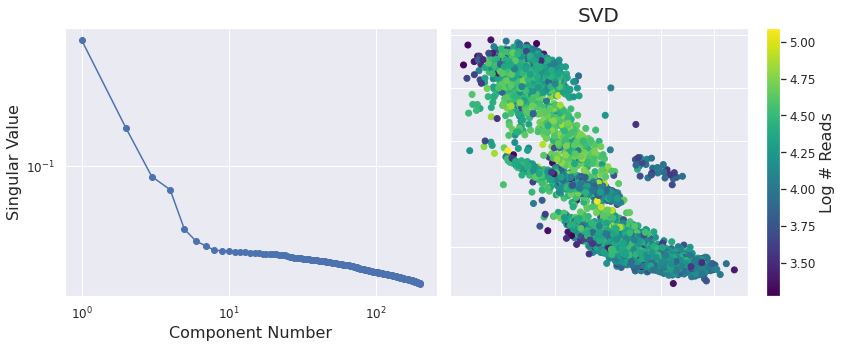

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

_ = ax1.plot(np.arange(adata.obsm['lsi'].shape[1]) + 1, SVDObj.singular_values_, '-o')
_ = ax1.set_xscale('log')
_ = ax1.set_yscale('log')
_ = ax1.set_xlabel("Component Number")
_ = ax1.set_ylabel("Singular Value")

hax2 = ax2.scatter(*adata.obsm['lsi'][:, :2].T, c=np.log10(adata.obs['n_reads']), cmap='viridis')
cax2 = plt.colorbar(hax2, ax=ax2, label='Log # Reads')

_ = ax2.set_xticklabels([])
_ = ax2.set_yticklabels([])
_ = ax2.set_title("SVD")

_ = fig.tight_layout()

 Examining the scree plot for the SVD components, we can see that 50 components should be more than sufficient to describe the data.

In [18]:
adata.obsm['lsi'] = adata.obsm['lsi'][:, :50]

We can then save the results to file for later use.

In [19]:
adata.write("../data/10kPBMC_scATAC/02_processed_data/atac_pbmc_10k_nextgem_preprocessed_data.h5ad")
np.savetxt("../data/10kPBMC_scATAC/02_processed_data/atac_pbmc_10k_nextgem_preprocessed_data.csv", adata.obsm['lsi'], delimiter=',')

/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'chromosome' as categorical
/home/emj760/miniconda3/envs/EMBEDR/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_name' as categorical
